**Copyright 2020 Google LLC.**

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

## Overview

### Generate synthetic datasets for various settings by sampling the original UCI_Adult dataset:

Pre-requisite: Download the Adult train and test data files can be downloaded from: https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test and save them in the ./group_agnostic_fairness/data/uci_adult folder.

This notebook contains code to create synthetic datasets over the original uci_adult dataset. We provide code to control various parameters like "base-rate", "group-size", and "label-noise" and generate synthetic dataset by over-sampling / under-samping original uci_adult training dataset.

In [0]:
from __future__ import division
import pandas as pd
import numpy as np
import json
import collections
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [0]:
sns.set_context('paper',font_scale=1.5)
dataset_base_dir = './group_agnostic_fairness/data/uci_adult/'

In [0]:
def sample_data(data_df, num=None, restrictions=None):
  """A recursive function that samples data according to the restrictions.

  Sampling is done with replacement.

  The restrictions determine how the data should be sampled.

  For example, 
  column_types = ['sex:Female','income:>50K']
  percentages =  [[0.33,0.6]]
  Returns an object of type Restriction, which can be used to sample a dataset 
  in which fraction of females is 0.33, and female-base-rate (females with income >50k) is 0.66. 
  Data for non-female group is sampled uniformly at random, 
  hence will have similar base-rate as in the original distribution.

  Args:
    data_df: A pandas DataFrame containing the dataset that should be sampled.
    num: The total number of samples needed.
    restrictions: A list of restrictions. Each restriction contains a column
      name, a list of types (a value for a bucket), and a list of percentages.
  Returns:
    A pandas DataFrame of size 'num' that holds up to each of the restrictions.
  """
  if not num:
    num = data_df.shape[0]
  if not restrictions:
    return data_df.sample(n=num,replace=True)
  num_other = num
  other_subset = np.full(data_df.shape[0], True)
  subsamples = []
  for tp, percent in zip(restrictions[0].types, restrictions[0].percentages):
    subset = data_df[restrictions[0].column_name] == tp
    num_samples = (int)(num * percent)
    subsamples.append(
        sample_data(data_df[subset], num_samples, restrictions[1:]))
    num_other -= num_samples
    other_subset = other_subset & (-subset)
  if num_other > 0:
    subsamples.append(
        sample_data(data_df[other_subset], num_other, restrictions=None))
  
  # Concat and shuffle
  sample_df = pd.concat(subsamples, ignore_index=True).sample(frac=1.0)
  return sample_df

In [0]:
def sample_data_and_flip_class_label(data_df, frac, flip_dict):
  """ Samples specified fraction of samples and flips their class label.
    flip_dict: A dictionary of the form {current_value:new_value}.
      Example {'<=50K':'>50K','>50K':'<=50K'}
  Returns:
    A pandas DataFrame with specified fraction of column values flipped
  """
  flip_df = data_df.sample(frac=frac)
  flip_df.replace(to_replace=flip_dict,inplace=True)
  keep_df = data_df.drop(flip_df.index).sample(frac=1.0)
  # Concat and shuffle
  sample_df = pd.concat([keep_df,flip_df]).sample(frac=1.0)
  return sample_df

In [0]:
Restriction = collections.namedtuple(
    'Restriction', ['column_name', 'types', 'percentages'])

def create_restrictions(column_types, percentages):
  """Creates a list of restrictions.

  For example, 
  column_types = ['sex:Female','income:>50K']
  percentages =  [[0.33,0.6]]
  Returns an object of type Restriction, which can be used to sample a dataset 
  in which fraction of females is 0.33, and female-base-rate (females with income >50k) is 0.66. 
  Data for non-female group is sampled uniformly at random, hence will have similar base-rate as in the original distribution.

  Args:
    column_types: A list of column type strings. They must be of the form
      '(column name):(type name)'.
    percentages: A list of percentages for each column type.
  Returns:
    A list of restrictions
  """
  # Parse through the lists and create columns. We can have multiple types for
  # one column name.
  restrictions_dict = collections.defaultdict(list)
  percentages_dict = collections.defaultdict(list)
  if column_types and percentages:
    for column_type, percentage in zip(column_types, percentages):
      column, tp = column_type.split(':')
      restrictions_dict[column].append(tp)
      percentages_dict[column].append(percentage)
  # Now create the restrictions.
  restrictions = []
  for k in restrictions_dict:
    restrictions.append(
        Restriction(k, restrictions_dict[k], percentages_dict[k]))
  return restrictions

## Load Training Dataset

In [0]:
TRAIN_FILE = os.path.join(dataset_base_dir,'adult.data')
feature_names = [
    "age", "workclass", "fnlwgt", "education", "education-num",
    "marital-status", "occupation", "relationship", "race", "sex",
    "capital-gain", "capital-loss", "hours-per-week", "native-country", "income"
]

with open(TRAIN_FILE, "r") as TRAIN_FILE:
  train_df = pd.read_csv(TRAIN_FILE,sep=',',names=feature_names)

In [0]:
train_df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


## Sample data to have a specified group-size: Testing if the data is sampled as expected:

#### Original data distribution

In [0]:
print('Female group-size in original train-data: {}'.format(len(train_df[(train_df.sex=='Female')])/len(train_df)))
print('Male group-size  in original data: {}'.format(len(train_df[(train_df.sex!='Female')])/len(train_df)))
print('Female base-rate in original train-data: {}'.format(len(train_df[(train_df.sex=='Female') & (train_df.income == '>50K')])/len(train_df[(train_df.sex=='Female')])))
print('Male base-rate in original data: {}'.format(len(train_df[(train_df.sex!='Female') & (train_df.income == '>50K')])/len(train_df[(train_df.sex!='Female')])))

Female group-size in original train-data: 0.33079450876815825
Male group-size  in original data: 0.6692054912318418
Female base-rate in original train-data: 0.10946058861758426
Male base-rate in original data: 0.3057365764111978


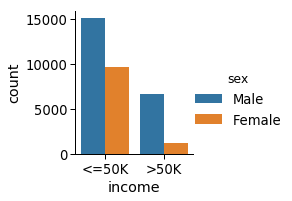

In [0]:
sns.catplot(data=train_df,x='income',hue='sex',kind='count',size=3)
plt.show()

#### Synthetic data distribution

In [0]:
column_types = ['sex:Female']
percentages = [0.4]
restrictions = create_restrictions(column_types,percentages)
print('Sampling data with restrictions: {}'.format(restrictions))
sampled_train_df = sample_data(train_df, restrictions=restrictions)

Sampling data with restrictions: [Restriction(column_name='sex', types=['Female'], percentages=[0.4])]


In [0]:
# Base-rate remains similar as in original distribution, group-size changes
print('Female group-size in synthetic data: {}'.format(len(sampled_train_df[(sampled_train_df.sex=='Female')])/len(sampled_train_df)))
print('Male group-size in synthetic data: {}'.format(len(sampled_train_df[(sampled_train_df.sex!='Female')])/len(sampled_train_df)))
print('Female base-rate in synthetic data: {}'.format(len(sampled_train_df[(sampled_train_df.sex=='Female') & (sampled_train_df.income == '>50K')])/len(sampled_train_df[(sampled_train_df.sex=='Female')])))
print('Male base-rate in synthetic data: {}'.format(len(sampled_train_df[(sampled_train_df.sex!='Female') & (sampled_train_df.income == '>50K')])/len(sampled_train_df[(sampled_train_df.sex!='Female')])))

Female group-size in synthetic data: 0.3999877153650072
Male group-size in synthetic data: 0.6000122846349928
Female base-rate in synthetic data: 0.10910626535626536
Male base-rate in synthetic data: 0.3041920458616983


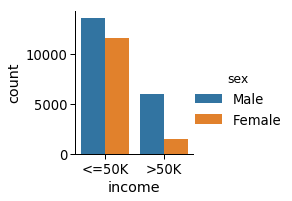

In [0]:
# Group sizes changes, base-rate remain the same.
sns.catplot(data=sampled_train_df,x='income',hue='sex',hue_order=['Male','Female'],order=['<=50K','>50K'],kind='count',size=3)
plt.show()

## Sample data to have a specified group base-rate: Testing if the data is sampled as expected:

#### Original data distribution

In [0]:
print('Female group-size in synthetic data: {}'.format(len(train_df[(train_df.sex=='Female')])/len(train_df)))
print('Male group-size in synthetic data: {}'.format(len(train_df[(train_df.sex!='Female')])/len(train_df)))
print('Female base-rate in original train-data: {}'.format(len(train_df[(train_df.sex=='Female') & (train_df.income == '>50K')])/len(train_df[(train_df.sex=='Female')])))
print('Male base-rate in original data: {}'.format(len(train_df[(train_df.sex!='Female') & (train_df.income == '>50K')])/len(train_df[(train_df.sex!='Female')])))

Female group-size in synthetic data: 0.33079450876815825
Male group-size in synthetic data: 0.6692054912318418
Female base-rate in original train-data: 0.10946058861758426
Male base-rate in original data: 0.3057365764111978


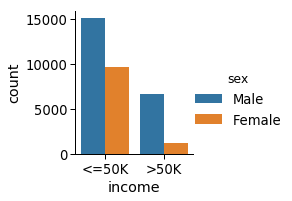

In [0]:
sns.catplot(data=train_df,x='income',hue='sex',kind='count',size=3)
plt.show()

#### Synthetic data distribution

In [0]:
column_types = ['sex:Female','income:>50K']
percentages = [0.33,0.30]
restrictions = create_restrictions(column_types,percentages)
print('Sampling data with restrictions: {}'.format(restrictions))
sampled_train_df = sample_data(train_df, restrictions=restrictions)

Sampling data with restrictions: [Restriction(column_name='sex', types=['Female'], percentages=[0.33]), Restriction(column_name='income', types=['>50K'], percentages=[0.3])]


In [0]:
print('Female group-size in synthetic data: {}'.format(len(sampled_train_df[(sampled_train_df.sex=='Female')])/len(sampled_train_df)))
print('Male group-size in synthetic data: {}'.format(len(sampled_train_df[(sampled_train_df.sex!='Female')])/len(sampled_train_df)))
print('Female base-rate in synthetic data: {}'.format(len(sampled_train_df[(sampled_train_df.sex=='Female') & (sampled_train_df.income == '>50K')])/len(sampled_train_df[(sampled_train_df.sex=='Female')])))
print('Male base-rate in synthetic data: {}'.format(len(sampled_train_df[(sampled_train_df.sex!='Female') & (sampled_train_df.income == '>50K')])/len(sampled_train_df[(sampled_train_df.sex!='Female')])))

Female group-size in synthetic data: 0.32999600749362734
Male group-size in synthetic data: 0.6700039925063727
Female base-rate in synthetic data: 0.29995346672871104
Male base-rate in synthetic data: 0.3092225889255592


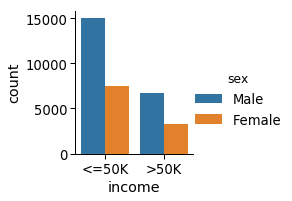

In [0]:
# Group sizes remain the same, base-rate changes.
sns.catplot(data=sampled_train_df,x='income',hue='sex',hue_order=['Male','Female'],order=['<=50K','>50K'],kind='count',size=3)
plt.show()

## Sample data with specified label-noise

In [0]:
fractions = [0.1, 0.2, 0.3, 0.4, 0.5]
for frac in fractions:
  for version in np.arange(10):
    sampled_train_df = sample_data_and_flip_class_label(train_df, frac=frac, flip_dict={'<=50K':'>50K','>50K':'<=50K'})
    output_file_path = os.path.join(dataset_base_dir,'income_flip_labels{}_version{}_train.csv'.format(frac,version)
    with open(output_file_path, mode="w") as output_file:
        sampled_train_df.to_csv(output_file,index=False,columns=feature_names,header=False)
        output_file.close()

## Sample data with specified group-sizes

In [0]:
column_types = ['sex:Female']
_percentages =  [[0.1],[0.2],[0.3],[0.4],[0.5],[0.6],[0.7],[0.8],[0.9]]
for percentages in _percentages:
  for version in np.arange(10):
    restrictions = create_restrictions(column_types,percentages)
    sampled_train_df = sample_data(train_df, restrictions=restrictions)

    output_file_path = os.path.join(dataset_base_dir,'female_groupsize{}_version{}_train.csv'.format(percentages[0],version)
    with open(output_file_path, mode="w") as output_file:
        sampled_train_df.to_csv(output_file,index=False,columns=feature_names,header=False)
        output_file.close()

## Sample data with specified base-rates

In [0]:
column_types = ['sex:Female','income:>50K']
_percentages =  [[0.33,0.1],[0.33,0.2],[0.33,0.3],[0.33,0.4],[0.33,0.5],[0.33,0.6],[0.33,0.7],[0.33,0.8],[0.33,0.9]]
for percentages in _percentages:
  for version in np.arange(10):
    restrictions = create_restrictions(column_types,percentages)
    sampled_train_df = sample_data(train_df, restrictions=restrictions)

    output_file_path = os.path.join(dataset_base_dir,'female_baserate{}_version{}_train.csv'.format(percentages[1],version)
    with open(output_file_path, mode="w") as output_file:
        sampled_train_df.to_csv(output_file,index=False,columns=feature_names,header=False)
        output_file.close()